In [1]:
import tensorflow as tf
import numpy as np
import io
import chess.pgn
import zstandard as zstd
import re

from bitboard import bitboard_to_array, bitboards_to_arrays, board_to_bitboards, array_to_bitboard, bitboards_to_board, arrays_to_bitboards

# Define a dictionary to map the color values to nice output strings
color_names = {
    chess.WHITE: "w",
    chess.BLACK: "b"
}

def data_generator_batch(batch_size):
    with open('./data/lichess_db_standard_rated_2023-06.pgn.zst', 'rb') as f:
        dctx = zstd.ZstdDecompressor()
        reader = dctx.stream_reader(f)
        text_stream = io.TextIOWrapper(reader, encoding='utf-8')
        
        # Initialize lists to store batch data
        batch_boards = []
        batch_move_numbers = []
        batch_evals = []
        batched_so_far = 0 # when this gets to 32, yield the batched data and reset to 0
        # Iterate over all games in the PGN file
        while True:
            number_of_games = 0
            
            game = chess.pgn.read_game(text_stream)
            if game is None:
                break
            
            # Check if the game has embedded Stockfish evaluations
            has_evaluations = any('[%eval ' in node.comment for node in game.mainline())
            if not has_evaluations:
                #print("found game with no eval")
                continue

            #print(game)
            
            number_of_games += 1
            
            # Count the number of moves in the main line
            num_moves = sum(1 for _ in game.mainline_moves())
            
            # Setup initial empty chess board
            board = chess.Board()
            
            # Iterate through all moves of the game
            for node in game.mainline():
                move = node.move
                board.push(move)

                # Get the comment (which contains the evaluation) for this move
                comment = node.comment
                match = re.search(r"\[%eval (.*?)\]", comment)
                if match is None:
                    #print(f"did not find a match when one was expected.")
                    continue
                
                score_str = match.group(1)
                
                # Convert mate in 'n' moves to large scores
                if '#' in score_str:
                    if '-' in score_str:
                        score = -150
                    else:
                        score = 150
                else:
                    score = float(score_str)
                
                # Convert the board position to bitboards and add to list
                bitboards = board_to_bitboards(board)
                batch_boards.append(bitboards_to_arrays(bitboards))
                batch_move_numbers.append(np.int16(board.ply()))
                batch_evals.append(np.float16(score))
                batched_so_far += 1
                try:
                    assert(len(batch_boards) == batched_so_far)
                    assert(len(batch_move_numbers) == batched_so_far)
                    assert(len(batch_evals) == batched_so_far)
                except Exception as e:
                    print("These should match", e)
                    
                #print(f"game: {number_of_games} move: {board.ply()}/{num_moves} {move.uci()} next: {color_names[np.int32(board.turn)]} score: {np.float16(score)}")
                #print(board)
                if batched_so_far == batch_size:
                    batched_so_far = 0
                    # print(f"batch_size: {batch_size}")
                    # print(f"len(batch_boards): {len(batch_boards)}")
                    # print(f"len(batch_move_numbers): {len(batch_move_numbers)}")
                    # print(f"len(batch_evals): {len(batch_evals)}")
                    # Convert batch data to numpy arrays
                    batch_boards = np.array(batch_boards, dtype=np.int16)
                    batch_move_numbers = np.array(batch_move_numbers, dtype=np.int16)
                    batch_evals = np.array(batch_evals, dtype=np.float16)
                    # Yield batch data
                    yield ((batch_boards, batch_move_numbers), batch_evals)
                    # Initialize lists to store batch data
                    batch_boards = []
                    batch_move_numbers = []
                    batch_evals = []
  

# Use batch generator to create dataset
batch_size = 1
dataset = tf.data.Dataset.from_generator(
    lambda: data_generator_batch(batch_size),  # Change 32 to the batch size you want
    output_signature=(
        (tf.TensorSpec(shape=(None, 8, 8, 12), dtype=tf.int16),
         tf.TensorSpec(shape=(None,), dtype=tf.int16)),
        tf.TensorSpec(shape=(None,), dtype=tf.float16)
    )
)

2023-07-31 22:44:32.416725: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 22:44:33.009028: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-31 22:44:33.791952: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-31 22:44:33.836477: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-31 22:44:33.836526: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_exec

for input, scores in dataset.take(3):
    print("+++++++++++++++++++++++++++++++++++++++++++")
    batch_of_arrays = input[0].numpy().tolist()
    moves = input[1].numpy().tolist()
    scores = scores.numpy().tolist()
    for list_of_arrays, move, score in zip(batch_of_arrays, moves, scores):
        print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
        bitboards = arrays_to_bitboards(list_of_arrays)
        board = bitboards_to_board(bitboards)
        print(board)
        print(f"move: {move} score: {score}")

In [2]:
n_data = 1000
dataset_subset = dataset.take(n_data)

In [3]:
from tensorflow.keras import layers

# input shape for the board is 8x8x12
board_input = layers.Input(shape=(8, 8, 12))

# input for the move number is a single scalar
move_number_input = layers.Input(shape=(1,))

# Add several convolutional layers to process the board
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(board_input)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
# Concatenate the processed board and move number inputs
x = layers.Concatenate()([x, move_number_input])  # move_number_input is directly used here

# Add more fully-connected layers
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)

# Add an output layer, assuming we're doing regression to predict the evaluation score
output_layer = layers.Dense(1)(x)

# Create the model
model = tf.keras.Model(inputs=(board_input, move_number_input), outputs=output_layer)

model.summary()

# Compile the model, using mean squared error as the loss function for regression
model.compile(optimizer='adam', loss='mse')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8, 8, 12)]           0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 8, 8, 64)             6976      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 8, 8, 64)             256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 64)             36928     ['batch_normalization[0][0

In [4]:
def predict(fen):
    board = chess.Board(fen)
    move_number_int = np.int16(board.ply())
    bb = bitboards_to_arrays(board_to_bitboards(board))
    bb = np.array([bb])
    pp = np.array([move_number_int])
    prediction = model.predict((bb, pp), verbose = 0)
    return prediction

2023-07-31 22:44:36.127080: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902


i: -1 Opera prediction: [[0.3720953]]
i: -1 Donald Byrne and Bobby Fischer 1956 prediction: [[0.33693546]]
i: -1 Garry Kasparov and Anatoly Karpov 1985 prediction: [[0.3851213]]
Epoch 1/10


2023-07-31 22:44:37.486580: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-31 22:44:38.416529: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55e295ee3ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-31 22:44:38.416561: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2023-07-31 22:44:38.420388: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-31 22:44:38.497884: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    992/Unknown - 8s 6ms/step - loss: 611.9620

2023-07-31 22:44:45.773945: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 14223242737729284430
2023-07-31 22:44:45.773996: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10734833072739697366
2023-07-31 22:44:45.774003: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9697261085526918004
2023-07-31 22:44:45.774006: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9977659975665788216
2023-07-31 22:44:46.039146: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1006878720 exceeds 10% of free system memory.


1000/1000 [==============================] - 9s 6ms/step - loss: 607.1284
Epoch 2/10
 999/1000 [============================>.] - ETA: 0s - loss: 782.5659

2023-07-31 22:44:52.307435: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1006878720 exceeds 10% of free system memory.


1000/1000 [==============================] - 6s 6ms/step - loss: 781.8615
Epoch 3/10
 992/1000 [============================>.] - ETA: 0s - loss: 832.7709

2023-07-31 22:44:58.680908: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1006878720 exceeds 10% of free system memory.


1000/1000 [==============================] - 6s 6ms/step - loss: 826.6887
Epoch 4/10
 999/1000 [============================>.] - ETA: 0s - loss: 722.9204

2023-07-31 22:45:04.846066: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1006878720 exceeds 10% of free system memory.


1000/1000 [==============================] - 6s 6ms/step - loss: 722.2281
Epoch 5/10
 991/1000 [============================>.] - ETA: 0s - loss: 814.2714

2023-07-31 22:45:10.925209: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1006878720 exceeds 10% of free system memory.


1000/1000 [==============================] - 6s 6ms/step - loss: 807.1631
Epoch 6/10
1000/1000 [==============================] - 6s 6ms/step - loss: 699.4011
Epoch 7/10
1000/1000 [==============================] - 6s 6ms/step - loss: 674.1160
Epoch 8/10
1000/1000 [==============================] - 6s 6ms/step - loss: 756.5737
Epoch 9/10
1000/1000 [==============================] - 6s 6ms/step - loss: 903.4875
Epoch 10/10
1000/1000 [==============================] - 6s 6ms/step - loss: 540.0080


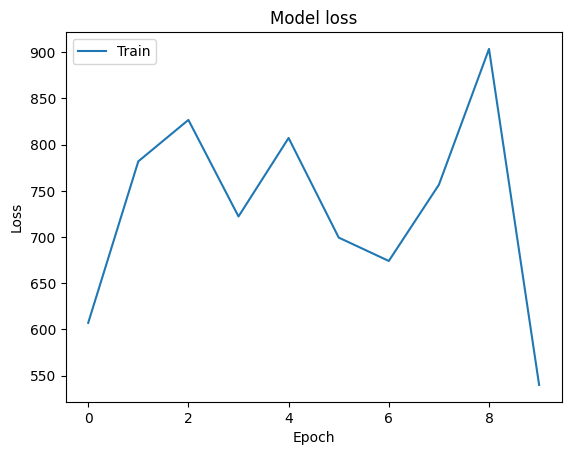

i: 0 Opera prediction: [[0.5820761]]
i: 0 Donald Byrne and Bobby Fischer 1956 prediction: [[-0.45232546]]
i: 0 Garry Kasparov and Anatoly Karpov 1985 prediction: [[-0.4874184]]
Epoch 1/10


/home/jerry/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


    993/Unknown - 7s 7ms/step - loss: 541.5381

2023-07-31 22:45:49.953761: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 14223242737729284430
2023-07-31 22:45:49.953800: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9697261085526918004


1000/1000 [==============================] - 7s 7ms/step - loss: 537.7543
Epoch 2/10
1000/1000 [==============================] - 7s 7ms/step - loss: 698.6647
Epoch 3/10
1000/1000 [==============================] - 7s 7ms/step - loss: 552.3145
Epoch 4/10
1000/1000 [==============================] - 7s 7ms/step - loss: 646.4308
Epoch 5/10
1000/1000 [==============================] - 7s 7ms/step - loss: 371.7735
Epoch 6/10
1000/1000 [==============================] - 6s 6ms/step - loss: 399.1057
Epoch 7/10
1000/1000 [==============================] - 7s 7ms/step - loss: 460.7442
Epoch 8/10
1000/1000 [==============================] - 7s 7ms/step - loss: 383.1127
Epoch 9/10
1000/1000 [==============================] - 7s 7ms/step - loss: 357.8111
Epoch 10/10
1000/1000 [==============================] - 7s 7ms/step - loss: 354.9012


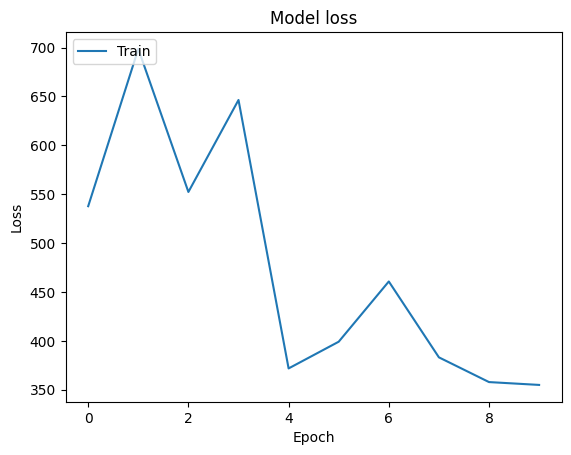

i: 10 Opera prediction: [[0.09092936]]
i: 10 Donald Byrne and Bobby Fischer 1956 prediction: [[0.09092936]]
i: 10 Garry Kasparov and Anatoly Karpov 1985 prediction: [[0.09092936]]
Epoch 1/10
    994/Unknown - 7s 7ms/step - loss: 441.4265

2023-07-31 22:46:58.213517: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 14223242737729284430
2023-07-31 22:46:58.213581: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10734833072739697366
2023-07-31 22:46:58.213589: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9697261085526918004
2023-07-31 22:46:58.213610: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9977659975665788216


1000/1000 [==============================] - 8s 7ms/step - loss: 438.7787
Epoch 2/10
1000/1000 [==============================] - 7s 7ms/step - loss: 367.0135
Epoch 3/10
1000/1000 [==============================] - 7s 7ms/step - loss: 421.9605
Epoch 4/10
1000/1000 [==============================] - 7s 7ms/step - loss: 288.0005
Epoch 5/10
1000/1000 [==============================] - 8s 8ms/step - loss: 376.8004
Epoch 6/10
1000/1000 [==============================] - 7s 7ms/step - loss: 218.8726
Epoch 7/10
1000/1000 [==============================] - 7s 7ms/step - loss: 348.4129
Epoch 8/10
1000/1000 [==============================] - 7s 7ms/step - loss: 425.7072
Epoch 9/10
1000/1000 [==============================] - 7s 7ms/step - loss: 182.1181
Epoch 10/10
1000/1000 [==============================] - 7s 7ms/step - loss: 337.3272


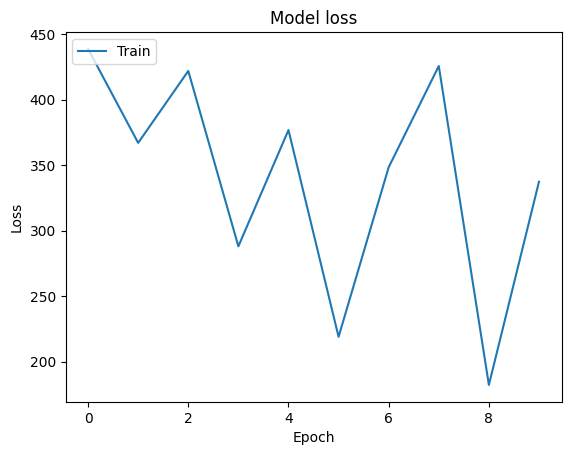

i: 20 Opera prediction: [[0.34624782]]
i: 20 Donald Byrne and Bobby Fischer 1956 prediction: [[0.34624782]]
i: 20 Garry Kasparov and Anatoly Karpov 1985 prediction: [[0.34624782]]
Epoch 1/10
    991/Unknown - 6s 6ms/step - loss: 233.8092

2023-07-31 22:48:08.134745: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 14223242737729284430
2023-07-31 22:48:08.134836: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10734833072739697366
2023-07-31 22:48:08.134844: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9697261085526918004
2023-07-31 22:48:08.134865: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9977659975665788216


1000/1000 [==============================] - 6s 6ms/step - loss: 231.7072
Epoch 2/10
1000/1000 [==============================] - 6s 6ms/step - loss: 205.2689
Epoch 3/10
1000/1000 [==============================] - 7s 6ms/step - loss: 551.5174
Epoch 4/10
 122/1000 [==>...........................] - ETA: 7s - loss: 783.5240

In [ ]:
i = -1

# "Opera Game" played by Paul Morphy
fen = "1r3rk1/pp3ppp/3B4/2B1Pb2/q4N2/8/P3QPPP/R4RK1 b - - 6 17"
prediction = predict(fen)
print(f"i: {i} Opera prediction: {prediction}")

fen = "r3r1k1/pp3pbp/1qp1b1p1/2B5/2BP4/Q1n2N2/P4PPP/3R1K1R w - - 0 18"
prediction = predict(fen)
print(f"i: {i} Donald Byrne and Bobby Fischer 1956 prediction: {prediction}")

fen = "r1bq1rk1/pp3pbp/2nppnp1/2p5/4P3/2N2NP1/PP1PBPBP/R1BQR1K1 w - - 0 18"
prediction = predict(fen)
print(f"i: {i} Garry Kasparov and Anatoly Karpov 1985 prediction: {prediction}")



tb_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs", histogram_freq=1)

epochs = 10

for i in range(0, 100, 10):
    history = model.fit(dataset_subset, epochs=epochs, callbacks=[tb_callback])  # adjust epochs according to your need
    # Plot training & validation loss values
    import matplotlib.pyplot as plt
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')
    plt.show()
    model.save_weights(f"./data/my_model-{epochs+i}-{n_data}-{batch_size}.keras")
    model.save(f"./data/my_model-{str(epochs+i).zfill(3)}-{str(n_data).zfill(5)}-{str(batch_size).zfill(2)}.h5")
    
    # "Opera Game" played by Paul Morphy
    fen = "1r3rk1/pp3ppp/3B4/2B1Pb2/q4N2/8/P3QPPP/R4RK1 b - - 6 17"
    prediction = predict(fen)
    print(f"i: {i} Opera prediction: {prediction}")
    
    fen = "r3r1k1/pp3pbp/1qp1b1p1/2B5/2BP4/Q1n2N2/P4PPP/3R1K1R w - - 0 18"
    prediction = predict(fen)
    print(f"i: {i} Donald Byrne and Bobby Fischer 1956 prediction: {prediction}")

    fen = "r1bq1rk1/pp3pbp/2nppnp1/2p5/4P3/2N2NP1/PP1PBPBP/R1BQR1K1 w - - 0 18"
    prediction = predict(fen)
    print(f"i: {i} Garry Kasparov and Anatoly Karpov 1985 prediction: {prediction}")